# CORRECT efficiency plots v5

In this NB I use v5 of the training (shallow, 20 epochs) to plot:

- Effiency by the total number of jets in the event
- Efficiency by pt of the particle (normal binning and dynamic binning)
- Efficiency by eta for the Higgs only
- Efficiency by pt for b1 and b2 of the Higgs
- Efficiencies of ttH together
- A first attempt at an uncertainty for efficiency vs pt plots (for the Higgs only)

I also use the correct version of the fully matched dataset here.

## Initialise

In [59]:
import h5py
import awkward as ak
import pandas as pd
import vector
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
from matplotlib.colors import LogNorm
hep.style.use(hep.style.ROOT)
mpl.rcParams['figure.dpi'] = 50
vector.register_awkward()

In [2]:
df = h5py.File('./SPANet/0504_output_v5_matched_v3.h5','r')
df_input = h5py.File('./SPANet/data/tth_matched_3.h5','r')
#fields = ['pt','eta','phi','btag']
#jets = ak.zip({
#    f: df["INPUTS"]["Source"][f][()] for f in fields
#}, with_name="Momentum4D")
#jets["m"] = np.zeros_like(jets.pt)
#jets[0].tolist()

In [11]:
df_jets = ak.from_parquet("/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/all_jets_v6.parquet")
(jets,
partons_matched,
partons,
generator_info,
lepton_partons,
lepton_reco, 
met
) = ak.unzip(df_jets)
jets = ak.with_name(jets, name="Momentum4D")

In [12]:
# Get fully matched jets from df_jets
mask_fullymatched = ak.sum(jets.matched == True, axis=1)>=6
higgs = jets[jets.prov == 1]
jets = jets[ak.num(higgs) == 2]

w_or_t_jets = jets[(jets.prov == 5)|(jets.prov == 2)]
jets = jets[ak.num(w_or_t_jets) == 3]

lep_top = jets[jets.prov == 3]
jets = jets[ak.num(lep_top) == 1]

Maximum number of jets is 14


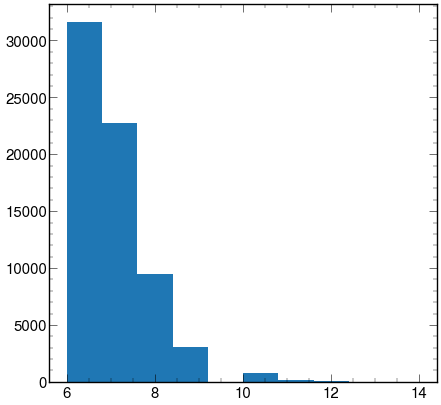

In [16]:
plt.hist(ak.num(jets));
print(f"Maximum number of jets is {max(ak.num(jets))}")

In [17]:
def get_leptop_arrays(n, njets, mode="partial"):

    # Leptonic top jets
    t2_b_pred = ak.Array(df["TARGETS"]["t2"]["b"][()])
    t2_b_pred = ak.unflatten(t2_b_pred, ak.ones_like(t2_b_pred))

    t2_b_true = ak.Array(df_input["TARGETS"]["t2"]["b"][()])
    t2_b_true = ak.unflatten(t2_b_true, ak.ones_like(t2_b_true))
    
    leptop_index_pred = t2_b_pred
    leptop_index_true = t2_b_true
    
    if mode == "partial":
        leptop_index_pred = leptop_index_pred[ak.num(jets)==n]
        leptop_index_true = leptop_index_true[ak.num(jets)==n]

    leptop_jet_pred = njets[leptop_index_pred]
    leptop_jet_true = njets[leptop_index_true]

    mask = (leptop_jet_true == leptop_jet_pred)
    leptop_pred_correct = leptop_jet_pred[mask] # correctly predicted jets
    leptop_pred_wrong = leptop_jet_pred[~mask] # wrongly predicted jets

    leptop_pred_correct = leptop_pred_correct[ak.num(leptop_pred_correct)>0]
    leptop_pred_wrong = leptop_pred_wrong[ak.num(leptop_pred_wrong)>0]

    return leptop_pred_correct, leptop_pred_wrong

def get_higgs_arrays(n, njets, mode="partial"):
    
    H_b1_true = ak.Array(df_input["TARGETS"]["h"]["b1"][()])
    H_b2_true = ak.Array(df_input["TARGETS"]["h"]["b2"][()])

    H_b1_true = ak.unflatten(H_b1_true, ak.ones_like(H_b1_true))
    H_b2_true = ak.unflatten(H_b2_true, ak.ones_like(H_b2_true))

    H_b1_pred = ak.Array(df["TARGETS"]["h"]["b1"][()])
    H_b2_pred = ak.Array(df["TARGETS"]["h"]["b2"][()])
    
    H_b1_pred = ak.unflatten(H_b1_pred, ak.ones_like(H_b1_pred))
    H_b2_pred = ak.unflatten(H_b2_pred, ak.ones_like(H_b2_pred))
 
    higgs_index_true = ak.concatenate((H_b1_true, H_b2_true), axis=1)
    higgs_index_pred = ak.concatenate((H_b1_pred, H_b2_pred), axis=1)
    
    if mode == "partial":
        higgs_index_true = higgs_index_true[ak.num(jets)==n]
        higgs_index_pred = higgs_index_pred[ak.num(jets)==n]

    higgs_jet_true = njets[higgs_index_true]
    higgs_jet_pred = njets[higgs_index_pred]
        
    mask = (higgs_jet_true == higgs_jet_pred)
    higgs_pred_correct = higgs_jet_pred[mask] # correctly predicted jets
    higgs_pred_wrong = higgs_jet_pred[~mask] # wrongly predicted jets

    higgs_pred_correct = higgs_pred_correct[ak.num(higgs_pred_correct)==2]
    higgs_pred_wrong = higgs_pred_wrong[ak.num(higgs_pred_wrong)>0]

    return higgs_pred_correct, higgs_pred_wrong

def get_hadtop_arrays(n, njets, mode="partial"):
    
    t1_q1_true = ak.Array(df_input["TARGETS"]["t1"]["q1"][()])
    t1_q2_true = ak.Array(df_input["TARGETS"]["t1"]["q2"][()])
    t1_b_true = ak.Array(df_input["TARGETS"]["t1"]["b"][()])

    t1_q1_true = ak.unflatten(t1_q1_true, ak.ones_like(t1_q1_true))
    t1_q2_true = ak.unflatten(t1_q2_true, ak.ones_like(t1_q2_true))
    t1_b_true = ak.unflatten(t1_b_true, ak.ones_like(t1_b_true))
    
    t1_q1_pred = ak.Array(df["TARGETS"]["t1"]["q1"][()])
    t1_q2_pred = ak.Array(df["TARGETS"]["t1"]["q2"][()])
    t1_b_pred = ak.Array(df["TARGETS"]["t1"]["b"][()])
    
    t1_q1_pred = ak.unflatten(t1_q1_pred, ak.ones_like(t1_q1_pred))
    t1_q2_pred = ak.unflatten(t1_q2_pred, ak.ones_like(t1_q2_pred))
    t1_b_pred = ak.unflatten(t1_b_pred, ak.ones_like(t1_b_pred))
 
    hadtop_index_true = ak.concatenate((t1_q1_true, t1_q2_true, t1_b_true), axis=1)
    hadtop_index_pred = ak.concatenate((t1_q1_pred, t1_q2_pred, t1_b_pred), axis=1)
    
    if mode == "partial":
        hadtop_index_true = hadtop_index_true[ak.num(jets)==n]
        hadtop_index_pred = hadtop_index_pred[ak.num(jets)==n]

    hadtop_jet_true = njets[hadtop_index_true]
    hadtop_jet_pred = njets[hadtop_index_pred]
        
    mask = (hadtop_jet_true == hadtop_jet_pred)
    hadtop_pred_correct = hadtop_jet_pred[mask] # correctly predicted jets
    hadtop_pred_wrong = hadtop_jet_pred[~mask] # wrongly predicted jets

    hadtop_pred_correct = hadtop_pred_correct[ak.num(hadtop_pred_correct)==3]
    hadtop_pred_wrong = hadtop_pred_wrong[ak.num(hadtop_pred_wrong)>0]

    return hadtop_pred_correct, hadtop_pred_wrong

def calculate_efficiency(particle, n, njets, mode="partial"):
    if particle == "h":
        pred_correct, pred_wrong = get_higgs_arrays(n, njets, mode)
    if particle == "t1":
        pred_correct, pred_wrong = get_hadtop_arrays(n, njets, mode)
    if particle == "t2":
        pred_correct, pred_wrong = get_leptop_arrays(n, njets, mode)
    print(f"\nNumber of correctly predicted within {n} jets is {len(pred_correct)}")
    print(f"Number of wrongly predicted within {n} jets is {len(pred_wrong)}")
    print(f"Total within {n} jets is {len(njets)}")
    
    purity = len(pred_correct)/len(njets)
    print(f"{n}-jet efficiency is {purity:.3f}")
    
    return pred_correct, pred_wrong

Plot the efficiency for the different particles for different number of jets. This should be the same as the table, which is:

![all_matched_purities_v5.png](all_matched_purities_v5.png)

## Leptonic top efficiency by njets

In [36]:
purities = []

for n in range(6,15):
    pred_correct, pred_wrong = calculate_efficiency("t2", n, jets[ak.num(jets)==n])
    purity = len(pred_correct)/(len(pred_correct)+len(pred_wrong))
    purities.append(purity)
    
n = "all"
pred_correct, pred_wrong = calculate_efficiency("t2", n, jets, mode="full")
purity = len(pred_correct)/(len(pred_correct)+len(pred_wrong))
purities.append(purity)

leptop_purities = purities


Number of correctly predicted within 6 jets is 18820
Number of wrongly predicted within 6 jets is 12776
Total within 6 jets is 31596
6-jet efficiency is 0.596

Number of correctly predicted within 7 jets is 13113
Number of wrongly predicted within 7 jets is 9661
Total within 7 jets is 22774
7-jet efficiency is 0.576

Number of correctly predicted within 8 jets is 5375
Number of wrongly predicted within 8 jets is 4083
Total within 8 jets is 9458
8-jet efficiency is 0.568

Number of correctly predicted within 9 jets is 1628
Number of wrongly predicted within 9 jets is 1404
Total within 9 jets is 3032
9-jet efficiency is 0.537

Number of correctly predicted within 10 jets is 435
Number of wrongly predicted within 10 jets is 380
Total within 10 jets is 815
10-jet efficiency is 0.534

Number of correctly predicted within 11 jets is 90
Number of wrongly predicted within 11 jets is 68
Total within 11 jets is 158
11-jet efficiency is 0.570

Number of correctly predicted within 12 jets is 22
N

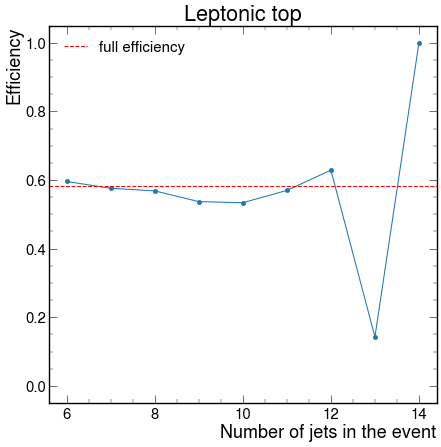

In [37]:
n = [6,7,8,9,10,11,12,13,14]
plt.plot(n, purities[:-1], marker='o')
plt.axhline(0.582, label="full efficiency", color='r', linestyle="--")
plt.xlabel("Number of jets in the event")
plt.ylabel("Efficiency")
plt.title("Leptonic top")
plt.ylim(-0.05,1.05)
plt.legend()
plt.show()

## Higgs efficiency by njets

In [38]:
purities = []

for n in range(6,15):
    pred_correct, pred_wrong = calculate_efficiency("h", n, jets[ak.num(jets)==n])
    purity = len(pred_correct)/(len(pred_correct)+len(pred_wrong))
    purities.append(purity)
    
n = "all"
pred_correct, pred_wrong = calculate_efficiency("h", n, jets, mode="full")
purity = len(pred_correct)/(len(pred_correct)+len(pred_wrong))
purities.append(purity)

higgs_purities = purities


Number of correctly predicted within 6 jets is 15043
Number of wrongly predicted within 6 jets is 16553
Total within 6 jets is 31596
6-jet efficiency is 0.476

Number of correctly predicted within 7 jets is 9778
Number of wrongly predicted within 7 jets is 12996
Total within 7 jets is 22774
7-jet efficiency is 0.429

Number of correctly predicted within 8 jets is 3941
Number of wrongly predicted within 8 jets is 5517
Total within 8 jets is 9458
8-jet efficiency is 0.417

Number of correctly predicted within 9 jets is 1163
Number of wrongly predicted within 9 jets is 1869
Total within 9 jets is 3032
9-jet efficiency is 0.384

Number of correctly predicted within 10 jets is 290
Number of wrongly predicted within 10 jets is 525
Total within 10 jets is 815
10-jet efficiency is 0.356

Number of correctly predicted within 11 jets is 60
Number of wrongly predicted within 11 jets is 98
Total within 11 jets is 158
11-jet efficiency is 0.380

Number of correctly predicted within 12 jets is 13
N

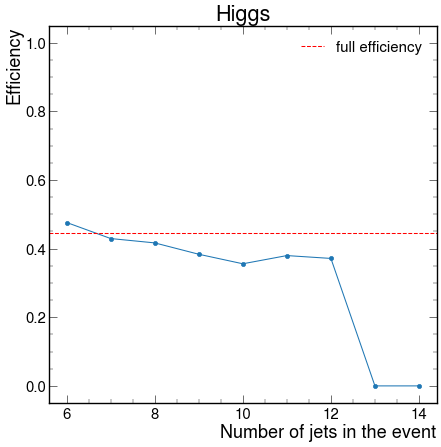

In [39]:
n = [6,7,8,9,10,11,12,13,14]
plt.plot(n, purities[:-1], marker='o')
plt.axhline(0.446, label="full efficiency", color='r', linestyle="--")
plt.xlabel("Number of jets in the event")
plt.ylabel("Efficiency")
plt.title("Higgs")
plt.ylim(-0.05,1.05)
plt.legend()
plt.show()

## Hadronic top efficiency by njets

In [40]:
purities = []

for n in range(6,15):
    pred_correct, pred_wrong = calculate_efficiency("t1", n, jets[ak.num(jets)==n])
    purity = len(pred_correct)/(len(pred_correct)+len(pred_wrong))
    purities.append(purity)
    
n = "all"
pred_correct, pred_wrong = calculate_efficiency("t1", n, jets, mode="full")
purity = len(pred_correct)/(len(pred_correct)+len(pred_wrong))
purities.append(purity)

hadtop_purities = purities


Number of correctly predicted within 6 jets is 20455
Number of wrongly predicted within 6 jets is 11141
Total within 6 jets is 31596
6-jet efficiency is 0.647

Number of correctly predicted within 7 jets is 12178
Number of wrongly predicted within 7 jets is 10596
Total within 7 jets is 22774
7-jet efficiency is 0.535

Number of correctly predicted within 8 jets is 4378
Number of wrongly predicted within 8 jets is 5080
Total within 8 jets is 9458
8-jet efficiency is 0.463

Number of correctly predicted within 9 jets is 1176
Number of wrongly predicted within 9 jets is 1856
Total within 9 jets is 3032
9-jet efficiency is 0.388

Number of correctly predicted within 10 jets is 278
Number of wrongly predicted within 10 jets is 537
Total within 10 jets is 815
10-jet efficiency is 0.341

Number of correctly predicted within 11 jets is 60
Number of wrongly predicted within 11 jets is 98
Total within 11 jets is 158
11-jet efficiency is 0.380

Number of correctly predicted within 12 jets is 6
N

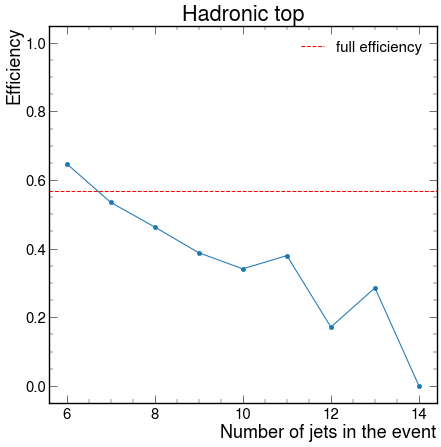

In [42]:
n = [6,7,8,9,10,11,12,13,14]
plt.plot(n, purities[:-1], marker='o')
plt.axhline(0.568, label="full efficiency", color='r', linestyle="--")
plt.xlabel("Number of jets in the event")
plt.ylabel("Efficiency")
plt.title("Hadronic top")
plt.ylim(-0.05,1.05)
plt.legend()
plt.show()

## Higgs efficiency by Higgs pt

In [51]:
H_b1_true = ak.Array(df_input["TARGETS"]["h"]["b1"][()])
H_b2_true = ak.Array(df_input["TARGETS"]["h"]["b2"][()])

H_b1_true = ak.unflatten(H_b1_true, ak.ones_like(H_b1_true))
H_b2_true = ak.unflatten(H_b2_true, ak.ones_like(H_b2_true))

H_b1_pred = ak.Array(df["TARGETS"]["h"]["b1"][()])
H_b2_pred = ak.Array(df["TARGETS"]["h"]["b2"][()])

H_b1_pred = ak.unflatten(H_b1_pred, ak.ones_like(H_b1_pred))
H_b2_pred = ak.unflatten(H_b2_pred, ak.ones_like(H_b2_pred))

higgs_index_true = ak.concatenate((H_b1_true, H_b2_true), axis=1)
higgs_index_pred = ak.concatenate((H_b1_pred, H_b2_pred), axis=1)

higgs_jet_true = jets[higgs_index_true]
higgs_jet_pred = jets[higgs_index_pred]

In [52]:
higgs_jet_true

<MomentumArray4D [[{pt: 126, eta: 2.37, ... prov: 1}]] type='67876 * var * Momen...'>

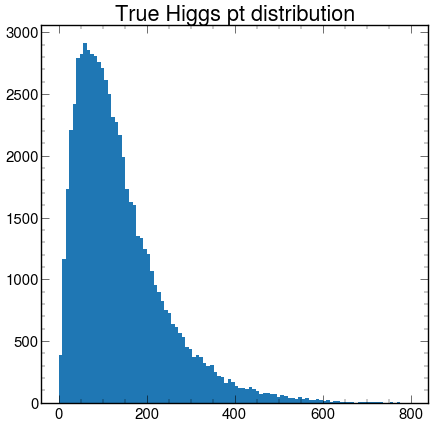

In [53]:
plt.hist((higgs_jet_true[:,0] + higgs_jet_true[:,1]).pt, bins=100, range=(0,800))
plt.title("True Higgs pt distribution");

In [54]:
higgs_true_pt = (higgs_jet_true[:,0] + higgs_jet_true[:,1]).pt
higgs_pred_pt = (higgs_jet_pred[:,0] + higgs_jet_pred[:,1]).pt
higgs_true_pt

<Array [166, 161, 189, 394, ... 276, 209, 106] type='67876 * float32'>

In [55]:
higgs_pred_pt

<Array [166, 161, 108, ... 276, 99.2, 48.3] type='67876 * float32'>

In [56]:
def find_bin(value, bins):
    """ bins is a list of tuples, like [(0,20), (20, 40), (40, 60)],
        binning returns the smallest index i of bins so that
        bin[i][0] <= value < bin[i][1]
    """
    for i in range(0, len(bins)):
        if bins[i][0] <= value < bins[i][1]:
            return i
    return -1

def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning. 
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0 
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """
    bins = []
    for low in range(lower_bound, lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins

In [111]:
def pt_efficiency(true_pt, pred_pt, nbins, binwidth):
    
    # Bin the array of predicted pts
    data = pd.DataFrame({"pt": pred_pt})

    bins = create_bins(lower_bound=0, width=binwidth, quantity=nbins)
    bin_means = []
    for i in range(len(bins)):
        bin_means.append((bins[i][0] + bins[i][1])/2)

    bins = pd.IntervalIndex.from_tuples(bins)
    data['pt_bin'] = pd.cut(data['pt'], bins=bins)
    
    # Find all counts (correctly and wrongly predicted -- denominator of efficiency)
    a = data['pt_bin'].value_counts(sort=False)
    a.index = a.index.astype(str)
    a = a.to_dict()
    all_counts = np.array(list(a.values()))
    
    # Construct correctly predicted and wrongly predicted jet pts
    mask = (true_pt == pred_pt)

    # Find counts of correctly predicted events
    data['correct'] = mask
    data = data[data['correct']==True]
    c = data['pt_bin'].value_counts(sort=False)
    c.index = c.index.astype(str)
    c = c.to_dict()
    correct_counts = np.array(list(c.values()))

    # Find the efficiency for each interval
    bin_efficiency = np.zeros(len(correct_counts))

    for i in range(len(all_counts)):
        if all_counts[i] > 0: # disregard empty bins and assign 0 efficiency to them
            bin_efficiency[i] = correct_counts[i]/all_counts[i]
        else:
            bin_efficiency[i] = 0
            
    return bin_means, bin_efficiency

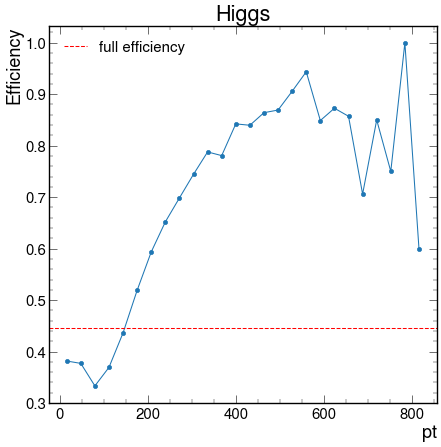

In [62]:
bin_means, bin_efficiency = pt_efficiency(higgs_true_pt, higgs_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.axhline(0.446, label="full efficiency", color='r', linestyle="--")
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Higgs")
plt.legend()
plt.show()

In [69]:
data = pd.DataFrame({"pt": higgs_pred_pt})

bins = create_bins(lower_bound=0, width=32, quantity=25)
bin_means = []
for i in range(len(bins)):
    bin_means.append((bins[i][0] + bins[i][1])/2)

bins = pd.IntervalIndex.from_tuples(bins)
data['pt_bin'] = pd.cut(data['pt'], bins=bins)

a = data['pt_bin'].value_counts(sort=False)
a.index = a.index.astype(str)
a = a.to_dict()
all_counts = np.array(list(a.values()))

print("TOTAL COUNTS IN EACH BIN")
data['pt_bin'].value_counts(sort=False) # TOTAL COUNTS IN EACH BIN

TOTAL COUNTS IN EACH BIN


(0, 32]        6742
(32, 64]      13014
(64, 96]      13381
(96, 128]     10252
(128, 160]     6871
(160, 192]     4581
(192, 224]     3339
(224, 256]     2511
(256, 288]     1880
(288, 320]     1436
(320, 352]     1084
(352, 384]      766
(384, 416]      539
(416, 448]      424
(448, 480]      309
(480, 512]      237
(512, 544]      159
(544, 576]      124
(576, 608]       86
(608, 640]       55
(640, 672]       28
(672, 704]       17
(704, 736]       20
(736, 768]        4
(768, 800]        3
(800, 832]        5
Name: pt_bin, dtype: int64

In [70]:
# Construct correctly predicted and wrongly predicted jet pts
mask = (higgs_true_pt == higgs_pred_pt)

# Find counts of correctly predicted events
data['correct'] = mask
data = data[data['correct']==True]

print("CORRECT COUNTS IN EACH BIN")
data['pt_bin'].value_counts(sort=False) # THE CORRECT COUNTS IN EACH BIN

CORRECT COUNTS IN EACH BIN


(0, 32]       2573
(32, 64]      4907
(64, 96]      4460
(96, 128]     3786
(128, 160]    2998
(160, 192]    2378
(192, 224]    1982
(224, 256]    1637
(256, 288]    1313
(288, 320]    1069
(320, 352]     854
(352, 384]     598
(384, 416]     454
(416, 448]     356
(448, 480]     267
(480, 512]     206
(512, 544]     144
(544, 576]     117
(576, 608]      73
(608, 640]      48
(640, 672]      24
(672, 704]      12
(704, 736]      17
(736, 768]       3
(768, 800]       3
(800, 832]       3
Name: pt_bin, dtype: int64

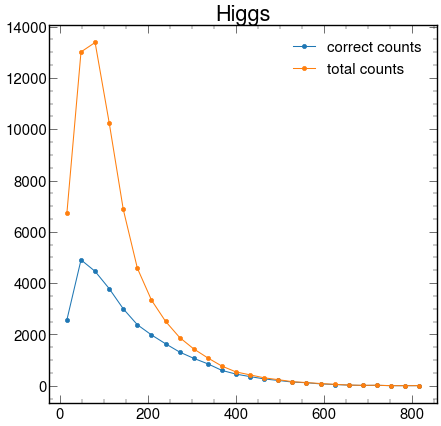

In [71]:
plt.plot(bin_means, correct_counts, marker='o', label="correct counts")
plt.plot(bin_means, all_counts, marker='o', label="total counts")
plt.title("Higgs")
plt.legend()
plt.show()

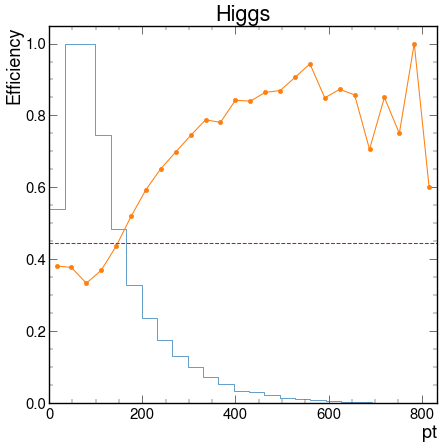

In [72]:
pred_pt = higgs_pred_pt[higgs_pred_pt <= 832]
pred_pt = pred_pt[pred_pt >= 0]
(counts, bins) = np.histogram(pred_pt, bins=25)
factor = 1/np.max(counts)
plt.hist(bins[:-1], bins, weights=factor*counts, histtype="step")
bin_means, bin_efficiency = pt_efficiency(higgs_true_pt, higgs_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Higgs")
plt.xlim(0,832)
plt.axhline(0.446, label="full efficiency", color='r', linestyle="--")
plt.show()

## Higgs efficiency by Higgs eta

In [73]:
higgs_true_eta = (higgs_jet_true[:,0] + higgs_jet_true[:,1]).eta
higgs_pred_eta = (higgs_jet_pred[:,0] + higgs_jet_pred[:,1]).eta

In [74]:
def eta_efficiency(true_eta, pred_eta, nbins, binwidth):
    
    # Bin the array of predicted etas
    data = pd.DataFrame({"eta": pred_eta})

    bins = create_bins(lower_bound=-4, width=binwidth, quantity=nbins)
    bin_means = []
    for i in range(len(bins)):
        bin_means.append((bins[i][0] + bins[i][1])/2)

    bins = pd.IntervalIndex.from_tuples(bins)
    data['eta_bin'] = pd.cut(data['eta'], bins=bins)
    
    # Find all counts (correctly and wrongly predicted -- denominator of efficiency)
    a = data['eta_bin'].value_counts(sort=False)
    a.index = a.index.astype(str)
    a = a.to_dict()
    all_counts = np.array(list(a.values()))
    
    # Construct correctly predicted and wrongly predicted jet pts
    mask = (true_eta == pred_eta)

    # Find counts of correctly predicted events
    data['correct'] = mask
    data = data[data['correct']==True]
    c = data['eta_bin'].value_counts(sort=False)
    c.index = c.index.astype(str)
    c = c.to_dict()
    correct_counts = np.array(list(c.values()))

    # Find the efficiency for each interval
    bin_efficiency = np.zeros(len(correct_counts))

    for i in range(len(all_counts)):
        if all_counts[i] > 0: # disregard empty bins and assign 0 efficiency to them
            bin_efficiency[i] = correct_counts[i]/all_counts[i]
        else:
            bin_efficiency[i] = 0
            
    return bin_means, bin_efficiency

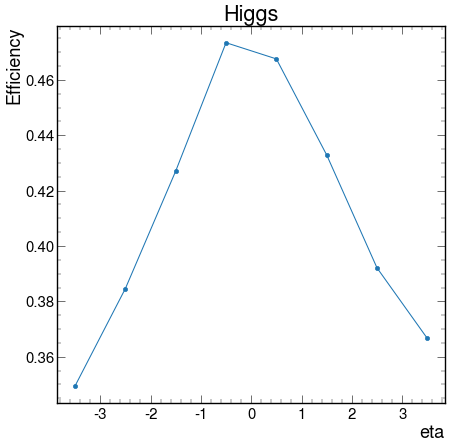

In [75]:
bin_means, bin_efficiency = eta_efficiency(higgs_true_eta, higgs_pred_eta, nbins=7, binwidth=1)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.xlabel("eta")
plt.ylabel("Efficiency")
plt.title("Higgs")
plt.show()

## Higgs quark efficiency by quark pt

In [76]:
H_b1_true = ak.Array(df_input["TARGETS"]["h"]["b1"][()])
H_b1_true = ak.unflatten(H_b1_true, ak.ones_like(H_b1_true))
H_b1_pred = ak.Array(df["TARGETS"]["h"]["b1"][()])
H_b1_pred = ak.unflatten(H_b1_pred, ak.ones_like(H_b1_pred))

H_b1_jet_true = jets[H_b1_true]
H_b1_jet_pred = jets[H_b1_pred]

b1_true_pt = H_b1_jet_true.pt
b1_pred_pt = H_b1_jet_pred.pt

b1_true_pt = ak.flatten(b1_true_pt)
b1_pred_pt = ak.flatten(b1_pred_pt)

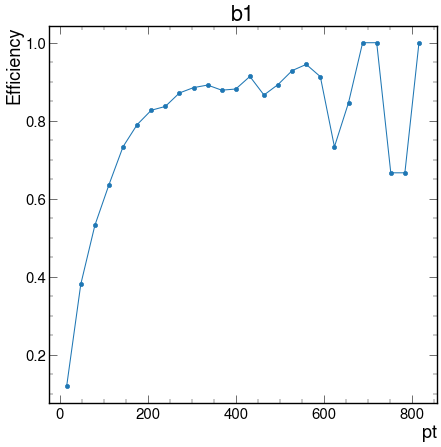

In [77]:
bin_means, bin_efficiency = pt_efficiency(b1_true_pt, b1_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("b1")
plt.show()

In [78]:
H_b2_true = ak.Array(df_input["TARGETS"]["h"]["b2"][()])
H_b2_true = ak.unflatten(H_b2_true, ak.ones_like(H_b2_true))
H_b2_pred = ak.Array(df["TARGETS"]["h"]["b2"][()])
H_b2_pred = ak.unflatten(H_b2_pred, ak.ones_like(H_b2_pred))

H_b2_jet_true = jets[H_b2_true]
H_b2_jet_pred = jets[H_b2_pred]

b2_true_pt = H_b2_jet_true.pt
b2_pred_pt = H_b2_jet_pred.pt

b2_true_pt = ak.flatten(b2_true_pt)
b2_pred_pt = ak.flatten(b2_pred_pt)

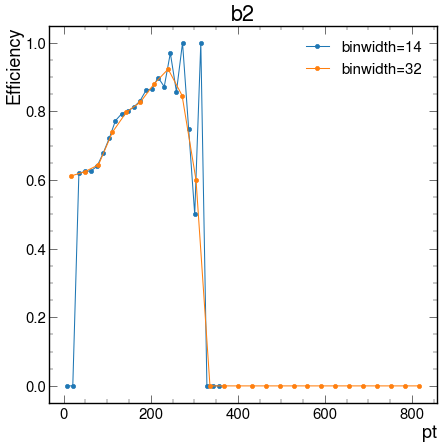

In [79]:
bin_means, bin_efficiency = pt_efficiency(b2_true_pt, b2_pred_pt, nbins=25, binwidth=14)
plt.plot(bin_means, bin_efficiency, marker='o', label="binwidth=14")
bin_means, bin_efficiency = pt_efficiency(b2_true_pt, b2_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o', label="binwidth=32")
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("b2")
plt.legend()
plt.show()

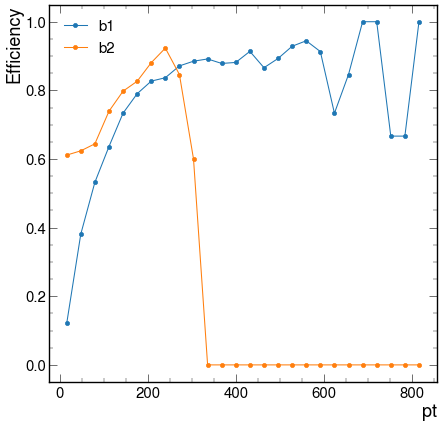

In [80]:
bin_means, bin_efficiency = pt_efficiency(b1_true_pt, b1_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o', label="b1")
bin_means, bin_efficiency = pt_efficiency(b2_true_pt, b2_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o', label="b2")
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.legend()
plt.show()

## Leptonic top efficiency by pt

In [110]:
t2_b_pred = ak.Array(df["TARGETS"]["t2"]["b"][()])
t2_b_pred = ak.unflatten(t2_b_pred, ak.ones_like(t2_b_pred))

t2_b_true = ak.Array(df_input["TARGETS"]["t2"]["b"][()])
t2_b_true = ak.unflatten(t2_b_true, ak.ones_like(t2_b_true))

leptop_index_pred = t2_b_pred
leptop_index_true = t2_b_true

leptop_jet_pred = jets[leptop_index_pred]
leptop_jet_true = jets[leptop_index_true]

leptop_pred_pt = leptop_jet_pred.pt
leptop_true_pt = leptop_jet_true.pt

leptop_pred_pt = ak.flatten(leptop_pred_pt)
leptop_true_pt = ak.flatten(leptop_true_pt)

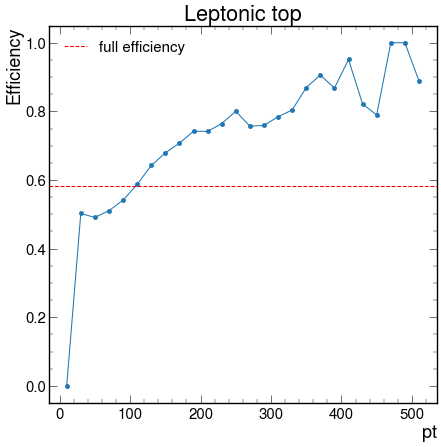

In [112]:
bin_means, bin_efficiency = pt_efficiency(leptop_true_pt, leptop_pred_pt, nbins=25, binwidth=20)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.axhline(0.582, label="full efficiency", color='r', linestyle="--")
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Leptonic top")
plt.legend()
plt.show()

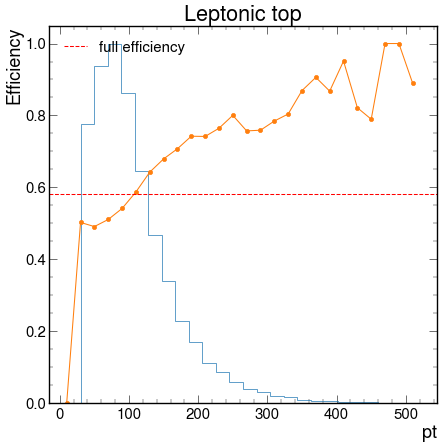

In [114]:
pred_pt = leptop_pred_pt[leptop_pred_pt <= 520]
pred_pt = pred_pt[pred_pt >= 0]
(counts, bins) = np.histogram(pred_pt, bins=25)
factor = 1/np.max(counts)
plt.hist(bins[:-1], bins, weights=factor*counts, histtype="step")

bin_means, bin_efficiency = pt_efficiency(leptop_true_pt, leptop_pred_pt, nbins=25, binwidth=20)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.axhline(0.582, label="full efficiency", color='r', linestyle="--")
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Leptonic top")
plt.legend()
plt.show()

## Hadronic top efficiency by pt

In [120]:
t1_q1_true = ak.Array(df_input["TARGETS"]["t1"]["q1"][()])
t1_q2_true = ak.Array(df_input["TARGETS"]["t1"]["q2"][()])
t1_b_true = ak.Array(df_input["TARGETS"]["t1"]["b"][()])

t1_q1_true = ak.unflatten(t1_q1_true, ak.ones_like(t1_q1_true))
t1_q2_true = ak.unflatten(t1_q2_true, ak.ones_like(t1_q2_true))
t1_b_true = ak.unflatten(t1_b_true, ak.ones_like(t1_b_true))

t1_q1_pred = ak.Array(df["TARGETS"]["t1"]["q1"][()])
t1_q2_pred = ak.Array(df["TARGETS"]["t1"]["q2"][()])
t1_b_pred = ak.Array(df["TARGETS"]["t1"]["b"][()])

t1_q1_pred = ak.unflatten(t1_q1_pred, ak.ones_like(t1_q1_pred))
t1_q2_pred = ak.unflatten(t1_q2_pred, ak.ones_like(t1_q2_pred))
t1_b_pred = ak.unflatten(t1_b_pred, ak.ones_like(t1_b_pred))

hadtop_index_true = ak.concatenate((t1_q1_true, t1_q2_true, t1_b_true), axis=1)
hadtop_index_pred = ak.concatenate((t1_q1_pred, t1_q2_pred, t1_b_pred), axis=1)

hadtop_jet_true = jets[hadtop_index_true]
hadtop_jet_pred = jets[hadtop_index_pred]

hadtop_pred_pt = (hadtop_jet_pred[:,0] + hadtop_jet_pred[:,1] + hadtop_jet_pred[:,2]).pt
hadtop_true_pt = (hadtop_jet_true[:,0] + hadtop_jet_true[:,1] + hadtop_jet_true[:,2]).pt

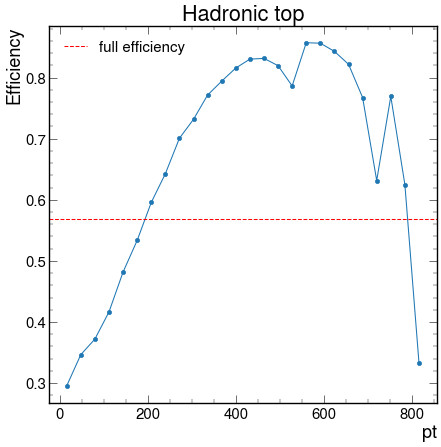

In [142]:
bin_means, bin_efficiency = pt_efficiency(hadtop_true_pt, hadtop_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.axhline(0.568, label="full efficiency", color='r', linestyle="--")
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Hadronic top")
plt.legend()
plt.show()
#plt.rcParams['figure.facecolor'] = 'white'
#plt.savefig("efficiencies.png", dpi=200)

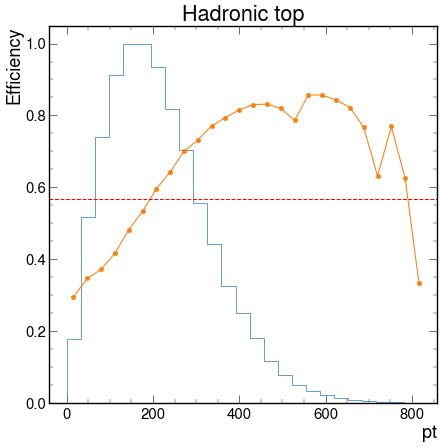

In [123]:
pred_pt = hadtop_pred_pt[hadtop_pred_pt <= 832]
pred_pt = pred_pt[pred_pt >= 0]
(counts, bins) = np.histogram(pred_pt, bins=25)
factor = 1/np.max(counts)
plt.hist(bins[:-1], bins, weights=factor*counts, histtype="step")

bin_means, bin_efficiency = pt_efficiency(hadtop_true_pt, hadtop_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Hadronic top")
plt.axhline(0.568, label="full efficiency", color='r', linestyle="--")
plt.show()

## Dynamic binning

In [ ]:
def pt_dynamic_efficiency(true_pt, pred_pt, nbins):
    
    # Bin the array of predicted pts
    data = pd.DataFrame({"pt": pred_pt})
    data['pt_bin'] = pd.qcut(data['pt'], q=nbins)
    
    bin_means = np.zeros(nbins)
    for i in range(nbins):
        bin_means[i] = data['pt_bin'].value_counts(sort=False).keys()[i].mid
    
    # Find all counts (correctly and wrongly predicted -- denominator of efficiency)
    a = data['pt_bin'].value_counts(sort=False)
    a.index = a.index.astype(str)
    a = a.to_dict()
    all_counts = np.array(list(a.values()))
    
    # Construct correctly predicted and wrongly predicted jet pts
    mask = (true_pt == pred_pt)

    # Find counts of correctly predicted events
    data['correct'] = mask
    data = data[data['correct']==True]
    c = data['pt_bin'].value_counts(sort=False)
    c.index = c.index.astype(str)
    c = c.to_dict()
    correct_counts = np.array(list(c.values()))

    # Find the efficiency for each interval
    bin_efficiency = np.zeros(len(correct_counts))

    for i in range(len(all_counts)):
        bin_efficiency[i] = correct_counts[i]/all_counts[i]
            
    return bin_means, bin_efficiency

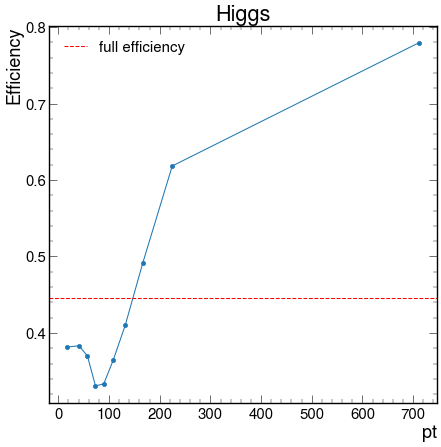

In [118]:
bin_means, bin_efficiency = pt_dynamic_efficiency(higgs_true_pt, higgs_pred_pt, nbins=10)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Higgs")
plt.axhline(0.446, label="full efficiency", color='r', linestyle="--")
plt.legend()
plt.show()

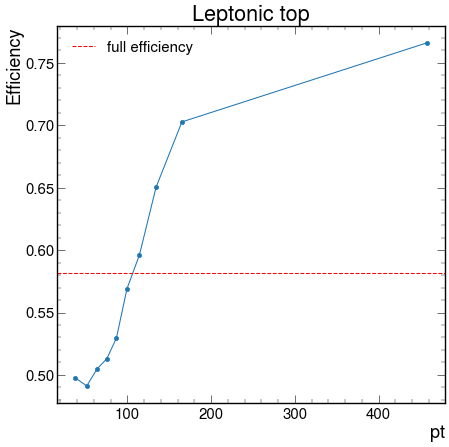

In [119]:
bin_means, bin_efficiency = pt_dynamic_efficiency(leptop_true_pt, leptop_pred_pt, nbins=10)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Leptonic top")
plt.axhline(0.582, label="full efficiency", color='r', linestyle="--")
plt.legend()
plt.show()

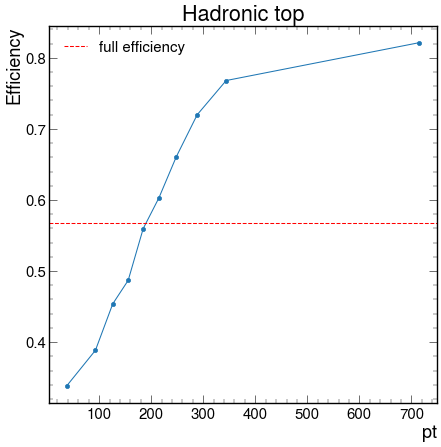

In [125]:
bin_means, bin_efficiency = pt_dynamic_efficiency(hadtop_true_pt, hadtop_pred_pt, nbins=10)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Hadronic top")
plt.axhline(0.568, label="full efficiency", color='r', linestyle="--")
plt.legend()
plt.show()

## All efficiencies

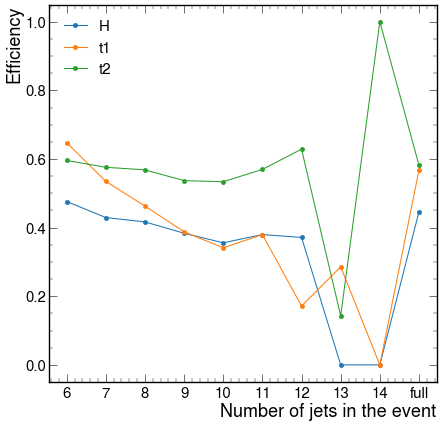

In [157]:
n = [6,7,8,9,10,11,12,13,14,"full"]
plt.plot(n, higgs_purities, marker='o', label="H")
plt.plot(n, hadtop_purities, marker='o', label="t1")
plt.plot(n, leptop_purities, marker='o', label="t2")
plt.xlabel("Number of jets in the event")
plt.ylabel("Efficiency")
plt.ylim(-0.05,1.05)
plt.legend()
plt.show()
#plt.rcParams['figure.facecolor'] = 'white'
#plt.savefig("efficiencies.png", dpi=200)

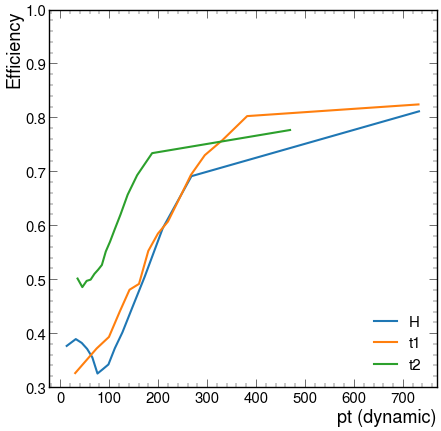

In [155]:
bin_means, bin_efficiency = pt_dynamic_efficiency(higgs_true_pt, higgs_pred_pt, nbins=15)
plt.plot(bin_means, bin_efficiency, linewidth=3, label="H")
bin_means, bin_efficiency = pt_dynamic_efficiency(hadtop_true_pt, hadtop_pred_pt, nbins=15)
plt.plot(bin_means, bin_efficiency, linewidth=3, label="t1")
bin_means, bin_efficiency = pt_dynamic_efficiency(leptop_true_pt, leptop_pred_pt, nbins=15)
plt.plot(bin_means, bin_efficiency, linewidth=3, label="t2")
plt.xlabel("pt (dynamic)")
plt.ylabel("Efficiency")
plt.ylim(0.3,1)
plt.legend(loc="lower right")
plt.show()

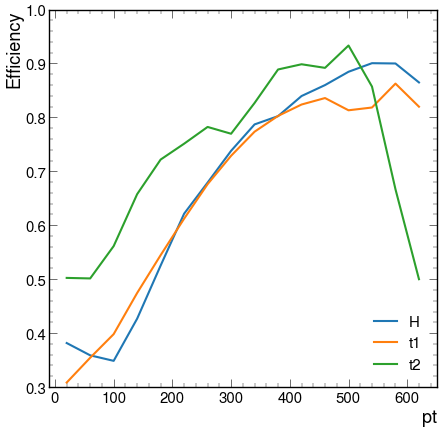

In [160]:
bin_means, bin_efficiency = pt_efficiency(higgs_true_pt, higgs_pred_pt,
                                          nbins=15, binwidth=40)
plt.plot(bin_means, bin_efficiency, linewidth=3, label="H")
bin_means, bin_efficiency = pt_efficiency(hadtop_true_pt, hadtop_pred_pt,
                                          nbins=15, binwidth=40)
plt.plot(bin_means, bin_efficiency, linewidth=3, label="t1")
bin_means, bin_efficiency = pt_efficiency(leptop_true_pt, leptop_pred_pt,
                                          nbins=15, binwidth=40)
plt.plot(bin_means, bin_efficiency, linewidth=3, label="t2")
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.ylim(0.3,1)
plt.legend(loc="lower right")
plt.show()

## Uncertainty attempt

$\text{efficiency}=\frac{\text{correct counts in bin}}{\text{all counts in bin}}$

Propagate uncertainty on the number of counts (Poisson statistical). Another source is the standard deviation inside each bin but I think Poisson is dominant

In [190]:
nbins=20
binwidth=32

data = pd.DataFrame({"pt": higgs_pred_pt})

bins = create_bins(lower_bound=0, width=binwidth, quantity=nbins)
bin_means = []
for i in range(len(bins)):
    bin_means.append((bins[i][0] + bins[i][1])/2)

bins = pd.IntervalIndex.from_tuples(bins)
data['pt_bin'] = pd.cut(data['pt'], bins=bins)

a = data['pt_bin'].value_counts(sort=False) # THE TOTAL COUNTS IN EACH BIN
a.index = a.index.astype(str)
a = a.to_dict()
all_counts = np.array(list(a.values()))

error_all_counts = np.sqrt(all_counts)

#print(all_counts)
#print(error_all_counts)

mask = (higgs_true_pt == higgs_pred_pt)
data['correct'] = mask
data = data[data['correct']==True]

a = data['pt_bin'].value_counts(sort=False) # THE CORRECT COUNTS IN EACH BIN
a.index = a.index.astype(str)
a = a.to_dict()
correct_counts = np.array(list(a.values()))

error_correct_counts = np.sqrt(correct_counts)

#print(correct_counts)
#print(error_correct_counts)

bin_efficiency = np.zeros(len(correct_counts))

for i in range(len(all_counts)):
    bin_efficiency[i] = correct_counts[i]/all_counts[i]

# For now only include Poisson error
error_efficiency = bin_efficiency * np.sqrt((error_correct_counts/correct_counts)**2 
                                            + (error_all_counts/all_counts)**2)
print(error_efficiency)

[0.00884358 0.00631645 0.00576294 0.00702312 0.00955042 0.01312015
 0.01683154 0.02070969 0.02511858 0.03007191 0.0360464  0.04260049
 0.05365614 0.06035643 0.07219866 0.08279669 0.1041854  0.1216099
 0.13508661 0.1723833  0.23843513]


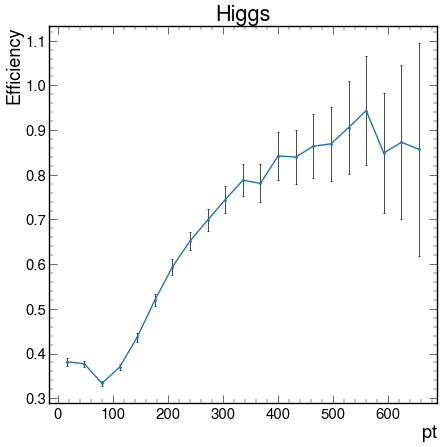

In [209]:
plt.errorbar(bin_means, bin_efficiency, error_efficiency,
             marker='.', ecolor='k', elinewidth=1, capsize=1.6, linewidth=2)
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Higgs")
plt.show()

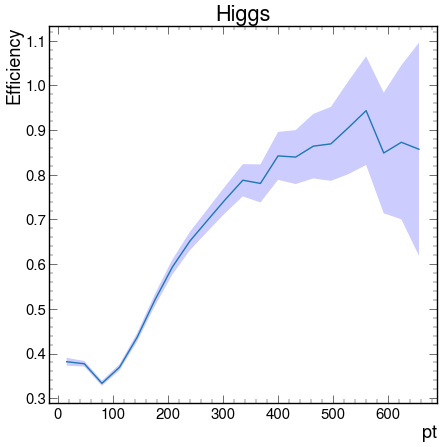

In [210]:
# 68% CI
plt.plot(bin_means, bin_efficiency, linewidth=2)
ci = error_efficiency
plt.fill_between(bin_means, bin_efficiency-ci, bin_efficiency+ci,
                 facecolor='blue',alpha=0.20, edgecolor='none')
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Higgs")
plt.show()

In [215]:
nbins = 20
data = pd.DataFrame({"pt": higgs_pred_pt})
data['pt_bin'] = pd.qcut(data['pt'], q=nbins)

bin_means = np.zeros(nbins)
for i in range(nbins):
    bin_means[i] = data['pt_bin'].value_counts(sort=False).keys()[i].mid

a = data['pt_bin'].value_counts(sort=False)
a.index = a.index.astype(str)
a = a.to_dict()
all_counts = np.array(list(a.values()))

mask = (higgs_true_pt == higgs_pred_pt)
data['correct'] = mask
data = data[data['correct']==True]
c = data['pt_bin'].value_counts(sort=False)
c.index = c.index.astype(str)
c = c.to_dict()
correct_counts = np.array(list(c.values()))

bin_efficiency = np.zeros(len(correct_counts))

for i in range(len(all_counts)):
    bin_efficiency[i] = correct_counts[i]/all_counts[i]
    
error_all_counts = np.sqrt(all_counts)
error_correct_counts = np.sqrt(correct_counts)

# For now only include Poisson error
error_efficiency = bin_efficiency * np.sqrt((error_correct_counts/correct_counts)**2 
                                            + (error_all_counts/all_counts)**2)

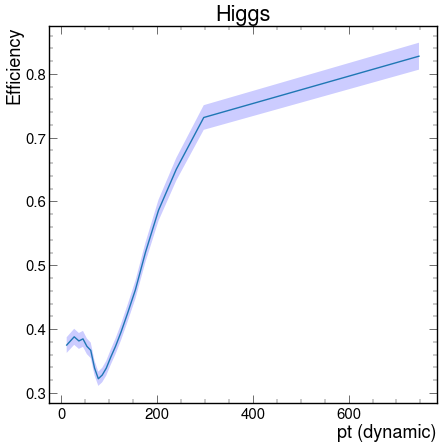

In [214]:
# 68% CI
plt.plot(bin_means, bin_efficiency, linewidth=2)
ci = error_efficiency
plt.fill_between(bin_means, bin_efficiency-ci, bin_efficiency+ci,
                 facecolor='blue',alpha=0.20, edgecolor='none')
plt.xlabel("pt (dynamic)")
plt.ylabel("Efficiency")
plt.title("Higgs")
plt.show()